# Yoga for the Yoga-less
Parker Servello


__Objective:__  
My friend frequently ruminates aloud about his dream of operating a yoga studio. This project will be the first step in making that dream become reality. Since we are going to Denver, Colorado next week, we will work under the assumption that he will fall in love with it and want to settle down there. We will determine the best location for this endeavor by clustering neighborhoods together that typically have yoga studios in them, then choosing an area within that cluster that either has too few or no yoga studios.  

__Data Collection:__  
We will leverage geo-location data for the neighborhoods listed in wikipedia as well as nearby venue data queried from foursquare's API for each neighborhood's coordinates. The clusters will be formed using the venue type frequency for each neighborhood.



In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import folium
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import metrics
from scipy.spatial.distance import cdist

## Extracting neighborhood geo-data from wikipedia

Get dataframe of neighborhood with their cardinal area and wiki href

In [1149]:
page = requests.get(r'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Denver')
soup = BeautifulSoup(page.text, 'lxml')

denver_division = [div.text for div in soup.find_all('span', class_='mw-headline')][:-3]

df = []
for div, lst in zip(denver_division,soup.find_all('ul')[1:11]):
    df.extend([(div, nbhd.text, nbhd['href']) for nbhd in lst.find_all('a')])
    
df = pd.DataFrame(df, columns=['Area','Neighborhood','href'])

df.head()

,Area,Neighborhood,href
0,Central,Baker,"/wiki/Baker,_Denver"
1,Central,Capitol Hill,"/wiki/Capitol_Hill,_Denver"
2,Central,Central Business District,/wiki/Downtown_Denver
3,Central,Cherry Creek,"/wiki/Cherry_Creek,_Denver"
4,Central,Cheesman Park,"/wiki/Cheesman_Park,_Denver"


Now we need to go to each of the hrefs on wikipedia to extract coordinates from the individual neighborhood pages.

In [1150]:
lat,lon = [],[]
for href in df['href']:
    
    url = 'https://en.wikipedia.org' + href
    
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'lxml')
    
    try:
        coord = soup.find_all('span', class_='geo')[0].text
        lat.append(coord.split(";")[0])
        lon.append(coord.split(" ")[1])
    
    except:
        lat.append("0")
        lon.append("0")

Add latitude and longitude to dataframe and remove the href column.

In [1151]:
df['Latitude'] = list(map(float,lat))
df['Longitude'] = list(map(float,lon))
df.drop('href', axis=1, inplace=True)

Some neighborhoods didn't have a wikipage, so we set their coordinates to 0 to easily filter them out. Let's remove them now.

In [1152]:
df = df[df['Latitude'] != 0].reset_index(drop=True)

## Exploring the neighborhoods

Initially there were 78 neighborhoods. 28 were removed because there is no associated wikipedia page. Also, let's get rid of the airport and Montbello because they are practically outside of Denver.


In [1153]:
#df = df[[nbhd not in ['Jefferson Park','Lincoln Park','Villa Park','City Park','Washington Park','Denver International Airport','Montbello'] for nbhd in df['Neighborhood']]]
df = df[[nbhd not in ['Denver International Airport','Montbello'] for nbhd in df['Neighborhood']]]

df.head()

,Area,Neighborhood,Latitude,Longitude
0,Central,Baker,39.723919,-104.995150
1,Central,Capitol Hill,39.733000,-104.983000
2,Central,Central Business District,39.745870,-104.992819
3,Central,Cherry Creek,39.720967,-104.949804
4,Central,Cheesman Park,39.732780,-104.965830


In [1154]:
# create map of Denver using latitude and longitude values
map_denver = folium.Map(location=[39.719, -104.95], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Area'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_denver)  
    
map_denver

## Requesting data from Foursquare

First, we need to enter credentials from a Foursquare account.

In [1155]:
CLIENT_ID = 'HSZABG5YEFOXOESF5NY2WCPNAKYIVUEB5IMWDLOMJD4GQWPK'
CLIENT_SECRET = '1Z110T2LFIS4R2XCYHYQEUBNPBOZQIWIKOO4KBBXV1KNBYB1'
VERSION = '20180605'

Now we can request the data.

Creating a function that extracts the nearby venues

In [1300]:
def get_nearby_venues(names, latitudes, longitudes, radius=1000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,  CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [1817]:
denver_venues = get_nearby_venues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])

There are going to be duplicate venues, so we should only attribute each venue to its' closest neighborhood. Let's compute the distance from each venue to each associated neighborhood.

In [1988]:
denver_venues['Venue Distance'] = np.sqrt((denver_venues['Neighborhood Latitude']-denver_venues['Venue Latitude'])**2+(denver_venues['Neighborhood Longitude']-denver_venues['Venue Longitude'])**2)
denver_venues[['Venue','Venue Distance']].head()

,Venue,Venue Distance
0,Zandi K Hair & Skin Studio,0.002811
1,space Gallery,0.003329
2,Trade,0.003611
3,Black Sky Brewery,0.003216
4,El Taco De Mexico,0.004946


Now we can get rid of the duplicates.

In [1989]:
denver_venues_reduced = denver_venues.sort_values('Venue Distance').drop_duplicates(['Venue','Venue Latitude','Venue Longitude'])
print("Removed {} duplicate venues.".format(len(denver_venues)-len(denver_venues_reduced)))

Removed 794 duplicate venues.


Let's see what categories they're from.

In [1990]:
print('There are {} uniques categories and {} unique venues.'.format(len(denver_venues_reduced['Venue Category'].unique()),len(denver_venues_reduced['Venue'].unique())))
denver_venues_reduced['Venue Category'].value_counts()

There are 282 uniques categories and 1893 unique venues.


Coffee Shop                    99
Mexican Restaurant             89
Pizza Place                    71
Park                           63
Bar                            62
American Restaurant            59
Brewery                        50
Sandwich Place                 46
Marijuana Dispensary           45
Convenience Store              44
Italian Restaurant             40
Hotel                          37
Liquor Store                   36
Fast Food Restaurant           33
Breakfast Spot                 32
Gym                            31
Grocery Store                  29
Restaurant                     28
Asian Restaurant               24
Café                           23
Sushi Restaurant               23
Spa                            22
Ice Cream Shop                 21
Cocktail Bar                   21
Gym / Fitness Center           21
Burger Joint                   19
Bakery                         19
Clothing Store                 18
Japanese Restaurant            17
Zoo Exhibit   

There are plenty of one off venue categories, we'll only include the ones that have at one instance.  

In [1991]:
category_counts = denver_venues_reduced['Venue Category'].value_counts()[list(map(lambda x: x>11, denver_venues_reduced['Venue Category'].value_counts()))]
categories = list(category_counts.index)
denver_venues_reduced = denver_venues_reduced[list(map(lambda x: x in categories,denver_venues_reduced['Venue Category']))]
print("Now we are down to {} unique venue categories and {} unique venues.".format(len(categories),len(denver_venues_reduced['Venue'].unique())))
denver_venues_reduced['Neighborhood'].value_counts()

Now we are down to 46 unique venue categories and 1145 unique venues.


Highland                     64
Berkeley                     63
Central Business District    60
Five Points                  59
City Park West               58
City Park                    53
Speer                        52
Cherry Creek                 51
LoDo                         51
University                   50
Montclair                    39
Jefferson Park               39
Washington Virginia Vale     38
North Capitol Hill           35
Lincoln Park                 34
Hale                         32
Belcaro                      30
Sloan Lake                   29
Baker                        29
Washington Park              28
Chaffee Park                 27
Cole                         25
Union Station                25
Globeville                   25
Valverde                     24
Sunnyside                    24
Golden Triangle              23
Capitol Hill                 22
Cheesman Park                22
Barnum                       21
Lowry                        21
Alamo Pl

We should only look at neighborhoods with at least 15 venues so that we have enough information to create meaningful clusters.

In [1992]:
nonsmall_neighborhoods = list(denver_venues_reduced['Neighborhood'].value_counts()[list(map(lambda x: x>15, denver_venues_reduced['Neighborhood'].value_counts()))].index)
denver_venues_reduced = denver_venues_reduced[[x in nonsmall_neighborhoods for x in denver_venues_reduced['Neighborhood']]]

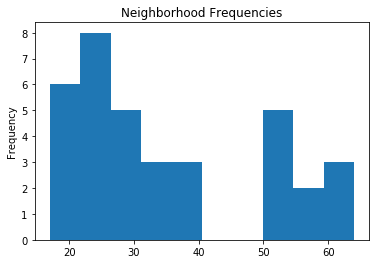

In [2053]:
denver_venues_reduced['Neighborhood'].value_counts().plot.hist(title="Neighborhood Frequencies", y='Neighborhoods')

We need to turn everything into categorical variables, so we'll do some one hot encoding.

In [1993]:
# one hot encoding
denver_onehot = pd.get_dummies(denver_venues_reduced[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
denver_onehot['Neighborhood'] = denver_venues_reduced['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [denver_onehot.columns[-1]] + list(denver_onehot.columns[:-1])
denver_onehot = denver_onehot[fixed_columns]

Standardizing and preparing the data for clustering

In [1994]:
denver_grouped_portioned = denver_onehot.groupby('Neighborhood').mean().reset_index()
denver_grouped_clustering = denver_grouped_portioned.drop('Neighborhood', 1)

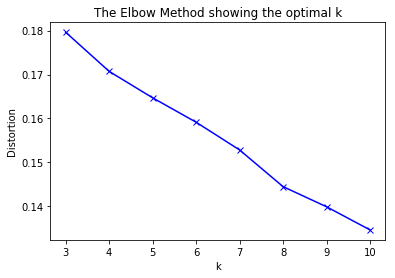

In [1995]:
# determine k using elbow method
distortions = []
K = range(3,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(denver_grouped_clustering)
    kmeanModel.fit(denver_grouped_clustering)
    distortions.append(sum(np.min(cdist(denver_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / denver_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


From the elbow method, we see that we should use 3 clusters.

In [1996]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(denver_grouped_clustering)

Let's make a dataframe to view the number of each venue category instance per neighborhood along with the clusters

In [1997]:
# get the count of each venue category instance by neighborhood
denver_grouped_portioned['Cluster'] = kmeans.labels_

Let's check how many neighborhoods are in each cluster and the number of yoga studios in each to be sure that they are account for.

In [1998]:
denver_grouped_sums = denver_onehot.groupby('Neighborhood').sum().reset_index()
denver_grouped_sums['Cluster'] = kmeans.labels_
yoga_df = denver_grouped_sums[['Cluster','Yoga Studio']].groupby('Cluster').sum()
yoga_df['Neighborhoods'] = denver_grouped_sums['Cluster'].value_counts().sort_index()
yoga_df['Average per Neighborhood'] = yoga_df['Yoga Studio']/yoga_df['Neighborhoods']
yoga_df

,Yoga Studio,Neighborhoods,Average per Neighborhood
Cluster,,,
0,0,2,0.000000
1,10,11,0.909091
2,0,1,0.000000
3,1,9,0.111111
4,1,3,0.333333
5,1,1,1.000000
6,0,1,0.000000
7,2,7,0.285714


Some of the neighborhoods are drastically different from the rest. Let's see if we can get rid of them and recluster.

In [1999]:
bad_clusters = list(yoga_df[(yoga_df['Neighborhoods']==1) | (yoga_df['Neighborhoods']==2)].index)
bad_neighborhoods = list(denver_grouped_portioned[[(x in bad_clusters) for x in denver_grouped_portioned['Cluster']]]['Neighborhood'])

print("Outlying neighborhoods include {}".format(", ".join(bad_neighborhoods)))

Outlying neighborhoods include Barnum, Belcaro, Central Business District, City Park, Sunnyside


In [2000]:
denver_grouped_portioned = denver_grouped_portioned[[x not in bad_neighborhoods for x in denver_grouped_portioned['Neighborhood']]]
denver_grouped_clustering = denver_grouped_portioned.drop('Neighborhood', 1)

denver_grouped_sums = denver_grouped_sums[[x not in bad_neighborhoods for x in denver_grouped_sums['Neighborhood']]]

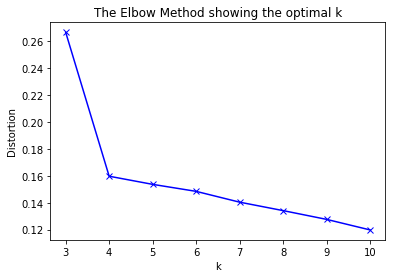

In [2001]:
# determine k using elbow method

# k means determine k
distortions = []
K = range(3,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(denver_grouped_clustering)
    kmeanModel.fit(denver_grouped_clustering)
    distortions.append(sum(np.min(cdist(denver_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / denver_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [2002]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(denver_grouped_clustering)

# get the count of each venue category instance by neighborhood
denver_grouped_sums['Cluster'] = kmeans.labels_
denver_grouped_sums.head()

yoga_df = denver_grouped_sums[['Cluster','Yoga Studio']].groupby('Cluster').sum()
yoga_df['Neighborhoods'] = denver_grouped_sums['Cluster'].value_counts().sort_index()
yoga_df['Average per Neighborhood'] = yoga_df['Yoga Studio']/yoga_df['Neighborhoods']
yoga_df

,Yoga Studio,Neighborhoods,Average per Neighborhood
Cluster,,,
0,2,7,0.285714
1,10,11,0.909091
2,1,9,0.111111
3,1,3,0.333333


In [2003]:
# create dataframe of neighborhood coordinates and clusters
denver_merged = df[[nbhd in set(denver_venues_reduced['Neighborhood']) for nbhd in df['Neighborhood']]]
denver_merged = denver_merged.merge(denver_grouped_sums[['Neighborhood','Cluster']])
denver_merged.head()

# create map
map_clusters = folium.Map(location=[39.719, -104.95], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.brg(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(denver_merged['Latitude'], denver_merged['Longitude'], denver_merged['Neighborhood'], denver_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's make a dataframe for the average number of each venue type per neighborhood for each cluster.

In [2021]:
# find the average number of each venue category per cluster
venue_clusters = denver_grouped_sums.groupby('Cluster').mean()
venue_clusters = venue_clusters

venue_clusters.head()

,American Restaurant,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Breakfast Spot,Brewery,Burger Joint,...,Pub,Restaurant,Salon / Barbershop,Sandwich Place,Spa,Steakhouse,Sushi Restaurant,Theater,Yoga Studio,Zoo Exhibit
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.714286,0.714286,0.714286,0.428571,0.428571,0.428571,2.428571,0.857143,0.714286,0.142857,...,0.428571,0.714286,0.285714,1.714286,1.000000,0.571429,0.285714,0.428571,0.285714,0.0
1,3.181818,0.454545,0.909091,0.454545,0.727273,0.181818,2.545455,1.363636,2.545455,1.181818,...,0.727273,1.000000,0.454545,1.181818,0.636364,0.363636,1.454545,0.454545,0.909091,0.0
2,0.444444,0.222222,0.444444,0.222222,0.222222,0.333333,0.444444,0.222222,1.222222,0.111111,...,0.111111,0.222222,0.555556,0.777778,0.333333,0.000000,0.444444,0.000000,0.111111,0.0
3,1.666667,0.000000,1.333333,0.333333,0.000000,0.333333,1.000000,0.666667,0.000000,0.000000,...,0.333333,0.333333,0.000000,1.333333,0.666667,0.000000,0.000000,0.333333,0.333333,0.0


Now we can see the average number of yoga studios per neighborhood by cluster.

In [2029]:
avg_yoga_per_neighborhood = venue_clusters['Yoga Studio']
yoga_cluster = avg_yoga_per_neighborhood.idxmax()
print("Cluster {} has the highest average number of yoga studios per neighborhood.".format(yoga_cluster))

Cluster 1 has the highest average number of yoga studios per neighborhood.


What's different about this cluster? Are there more of a specific venue type than other clusters?

In [2030]:
venue_clusters = venue_clusters.T
venue_clusters[venue_clusters.max(axis=1)==venue_clusters[yoga_cluster]]

Cluster,0,1,2,3
American Restaurant,0.714286,3.181818,0.444444,1.666667
BBQ Joint,0.428571,0.454545,0.222222,0.333333
Bakery,0.428571,0.727273,0.222222,0.000000
Bar,2.428571,2.545455,0.444444,1.000000
Breakfast Spot,0.857143,1.363636,0.222222,0.666667
Brewery,0.714286,2.545455,1.222222,0.000000
Burger Joint,0.142857,1.181818,0.111111,0.000000
Café,0.857143,1.090909,0.111111,0.000000
Clothing Store,0.285714,0.909091,0.333333,0.333333
Cocktail Bar,0.000000,1.636364,0.111111,0.000000


The brewery counts sticks out since it has twice the second clusters value. Is it possible that the same people who are interested in brewing are interested in yoga?

Now, are there less of a certain venue type?

In [2033]:
venue_clusters[venue_clusters.min(axis=1)==venue_clusters[yoga_cluster]]

Cluster,0,1,2,3
Bank,0.428571,0.181818,0.333333,0.333333
Dive Bar,0.571429,0.272727,0.444444,0.333333
Grocery Store,0.571429,0.545455,1.111111,1.000000
Liquor Store,0.428571,0.363636,1.555556,1.666667
Park,1.142857,0.636364,1.777778,3.000000
Zoo Exhibit,0.000000,0.000000,0.000000,0.000000


Clearly the yoga enthusiasts don't like to drink as much as the rest of the city, nor do they go to the bank as often.

Are there any neighborhoods in this cluster that do not have a yoga studio in them? If so, we should open one there!

In [2032]:
solution = list(denver_grouped_sums[(denver_grouped_sums['Yoga Studio']==0) & (denver_grouped_sums['Cluster']==yoga_cluster)]['Neighborhood'])
solution

['Auraria', 'City Park West', 'LoDo', 'Union Station']

Let's see the the area where we are going to set up the new yoga studio.

In [2007]:
# create map of Denver using latitude and longitude values
map_denver = folium.Map(location=[39.75, -104.998], zoom_start=14)

df_solution = df[[nbhd in solution for nbhd in df['Neighborhood']]]

# add markers to map
for lat, lng, borough, neighborhood in zip(df_solution['Latitude'], df_solution['Longitude'], df_solution['Area'], df_solution['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_denver)  
    
map_denver

This is right on the University of Colorado campus!  

My friend also wants to be a professor. Maybe he could teach at the university while he runs his yoga studio.